## Parameter based Algorithmic Trading Strategy using Neural Networks
> Author : Manas Baviskar TY_ETA_40

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import talib as ta
import yfinance as yf
import datetime

sns.set()

%matplotlib inline
warnings.filterwarnings('ignore')

c:\Users\MANAS\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\MANAS\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\MANAS\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
# Loading the data from the local file
start1=datetime.date(2000,1,2)
end1=datetime.date(2019,11,15)
df = yf.download('MSFT',start=start1,end=end1)
#df = pd.read_csv('EURUSD_data.csv', index_col=0, parse_dates=True)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Copying the original dataframe. Will work on the new dataframe.
data = df.copy()
# Checking the shape
print('Number of observations:', data.shape[0])
print('Number of variables:', data.shape[1])

Number of observations: 5000
Number of variables: 6


### Feature Engineering

In [5]:
# Creating features
features_list = []

# SD based features
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).std()
    features_list.append(col_name)
    
# MA based features
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)
    
# Daily pct change based features
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    data[col_name] = data['Close'].pct_change().rolling(i).sum()
    features_list.append(col_name)
    
# Intraday movement
col_name = 'co'
data[col_name] = data['Close'] - data['Open']
features_list.append(col_name)

In addition, We'll use popular technical indicators to build features. They are as follows:

- [Bolling Bands](https://en.wikipedia.org/wiki/Bollinger_Bands)
- [Moving Average Cross Over (MACD)](https://en.wikipedia.org/wiki/MACD)
- [Parabolic Stop And Reverse (SAR)](https://en.wikipedia.org/wiki/Parabolic_SAR)




In [6]:
data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(data['Close'].values)
data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['Close'].values)
data['sar'] = ta.SAR(data['High'].values, data['Low'].values)
features_list +=['upper_band','middle_band','lower_band','macd','sar']

ML algorithms don't work with `NaN` values. However, while creating the above features, we would have many `NaN` values we need to drop from our dataset.

In [7]:
features_list

['std_5',
 'std_10',
 'std_15',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_25',
 'pct_3',
 'pct_6',
 'pct_9',
 'co',
 'upper_band',
 'middle_band',
 'lower_band',
 'macd',
 'sar']

In [8]:
data[features_list].head()

std_5  std_10  std_15  ma_10  ma_15  ma_20  ma_25     pct_3  \
Date                                                                         
2000-01-03       NaN     NaN     NaN    NaN    NaN    NaN    NaN       NaN   
2000-01-04       NaN     NaN     NaN    NaN    NaN    NaN    NaN       NaN   
2000-01-05       NaN     NaN     NaN    NaN    NaN    NaN    NaN       NaN   
2000-01-06       NaN     NaN     NaN    NaN    NaN    NaN    NaN -0.056734   
2000-01-07  1.246754     NaN     NaN    NaN    NaN    NaN    NaN -0.009886   

            pct_6  pct_9       co  upper_band  middle_band  lower_band  macd  \
Date                                                                           
2000-01-03    NaN    NaN -0.40625         NaN          NaN         NaN   NaN   
2000-01-04    NaN    NaN -0.46875         NaN          NaN         NaN   NaN   
2000-01-05    NaN    NaN  1.34375         NaN          NaN         NaN   NaN   
2000-01-06    NaN    NaN -1.09375         NaN          NaN         NaN   NaN   
2000-01-07    NaN    NaN  1.40625   58.674011     56.44375   54.213489   NaN   

                sar  
Date                 
2000-01-03      NaN  
2000-01-04  56.0000  
2000-01-05  58.5625  
2000-01-06  58.5625  
2000-01-07  58.3875

In [9]:
data.dropna(inplace=True)

In [10]:
data[features_list].head()

std_5    std_10    std_15      ma_10      ma_15      ma_20  \
Date                                                                        
2000-02-18  0.945951  2.345893  2.077444  50.850000  50.960417  50.731250   
2000-02-22  1.214938  2.470136  2.275488  50.209375  50.825000  50.545313   
2000-02-23  1.236924  1.989512  2.456879  49.425000  50.535417  50.331250   
2000-02-24  1.177383  1.857604  2.589354  48.962500  50.333333  50.215625   
2000-02-25  0.744970  1.501594  2.816115  48.228125  49.922917  50.029688   

               ma_25     pct_3     pct_6     pct_9       co  upper_band  \
Date                                                                      
2000-02-18  51.47125 -0.034822 -0.105807 -0.109518 -2.46875   50.742169   
2000-02-22  51.10250 -0.038459 -0.061763 -0.153734 -0.65625   50.642097   
2000-02-23  50.68125 -0.054282 -0.053973 -0.095062  0.37500   50.250177   
2000-02-24  50.43625 -0.003181 -0.038003 -0.108988  0.25000   49.856167   
2000-02-25  50.14250 -0.026311 -0.064771 -0.088074 -1.68750   48.251393   

            middle_band  lower_band      macd        sar  
Date                                                      
2000-02-18     49.05000   47.357831 -1.735227  54.745075  
2000-02-22     48.46875   46.295403 -1.850419  54.452772  
2000-02-23     48.03750   45.824823 -1.902132  53.969981  
2000-02-24     47.75000   45.643833 -1.901028  53.334882  
2000-02-25     46.91875   45.586107 -2.015607  52.601394

As OHLC data is high correlated, we won't be using them as features. Instead, we would use only technical indicators and quantitative features for this exercise. Below we define feature matrix `X`, create the target variable and assign it to the target vector `y`.

In [11]:
import numpy as np

In [12]:
X = data[features_list]
data['target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
y = data['target']

We will use `train_test_split()` function from the `sklearn.model_selection` package to split our dataset. We will use 20% of our dataset as a test dataset.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3973, 16), (994, 16), (3973,), (994,))

Before we can train our neural network, we need to make sure that our data is scaled, that is, it ranges between 0 and 1. We will use `StandardScaler` from the `sklearn.preprocessing` package. We need to train the scaler object on training data only and then apply on training and testing set both.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


In [17]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

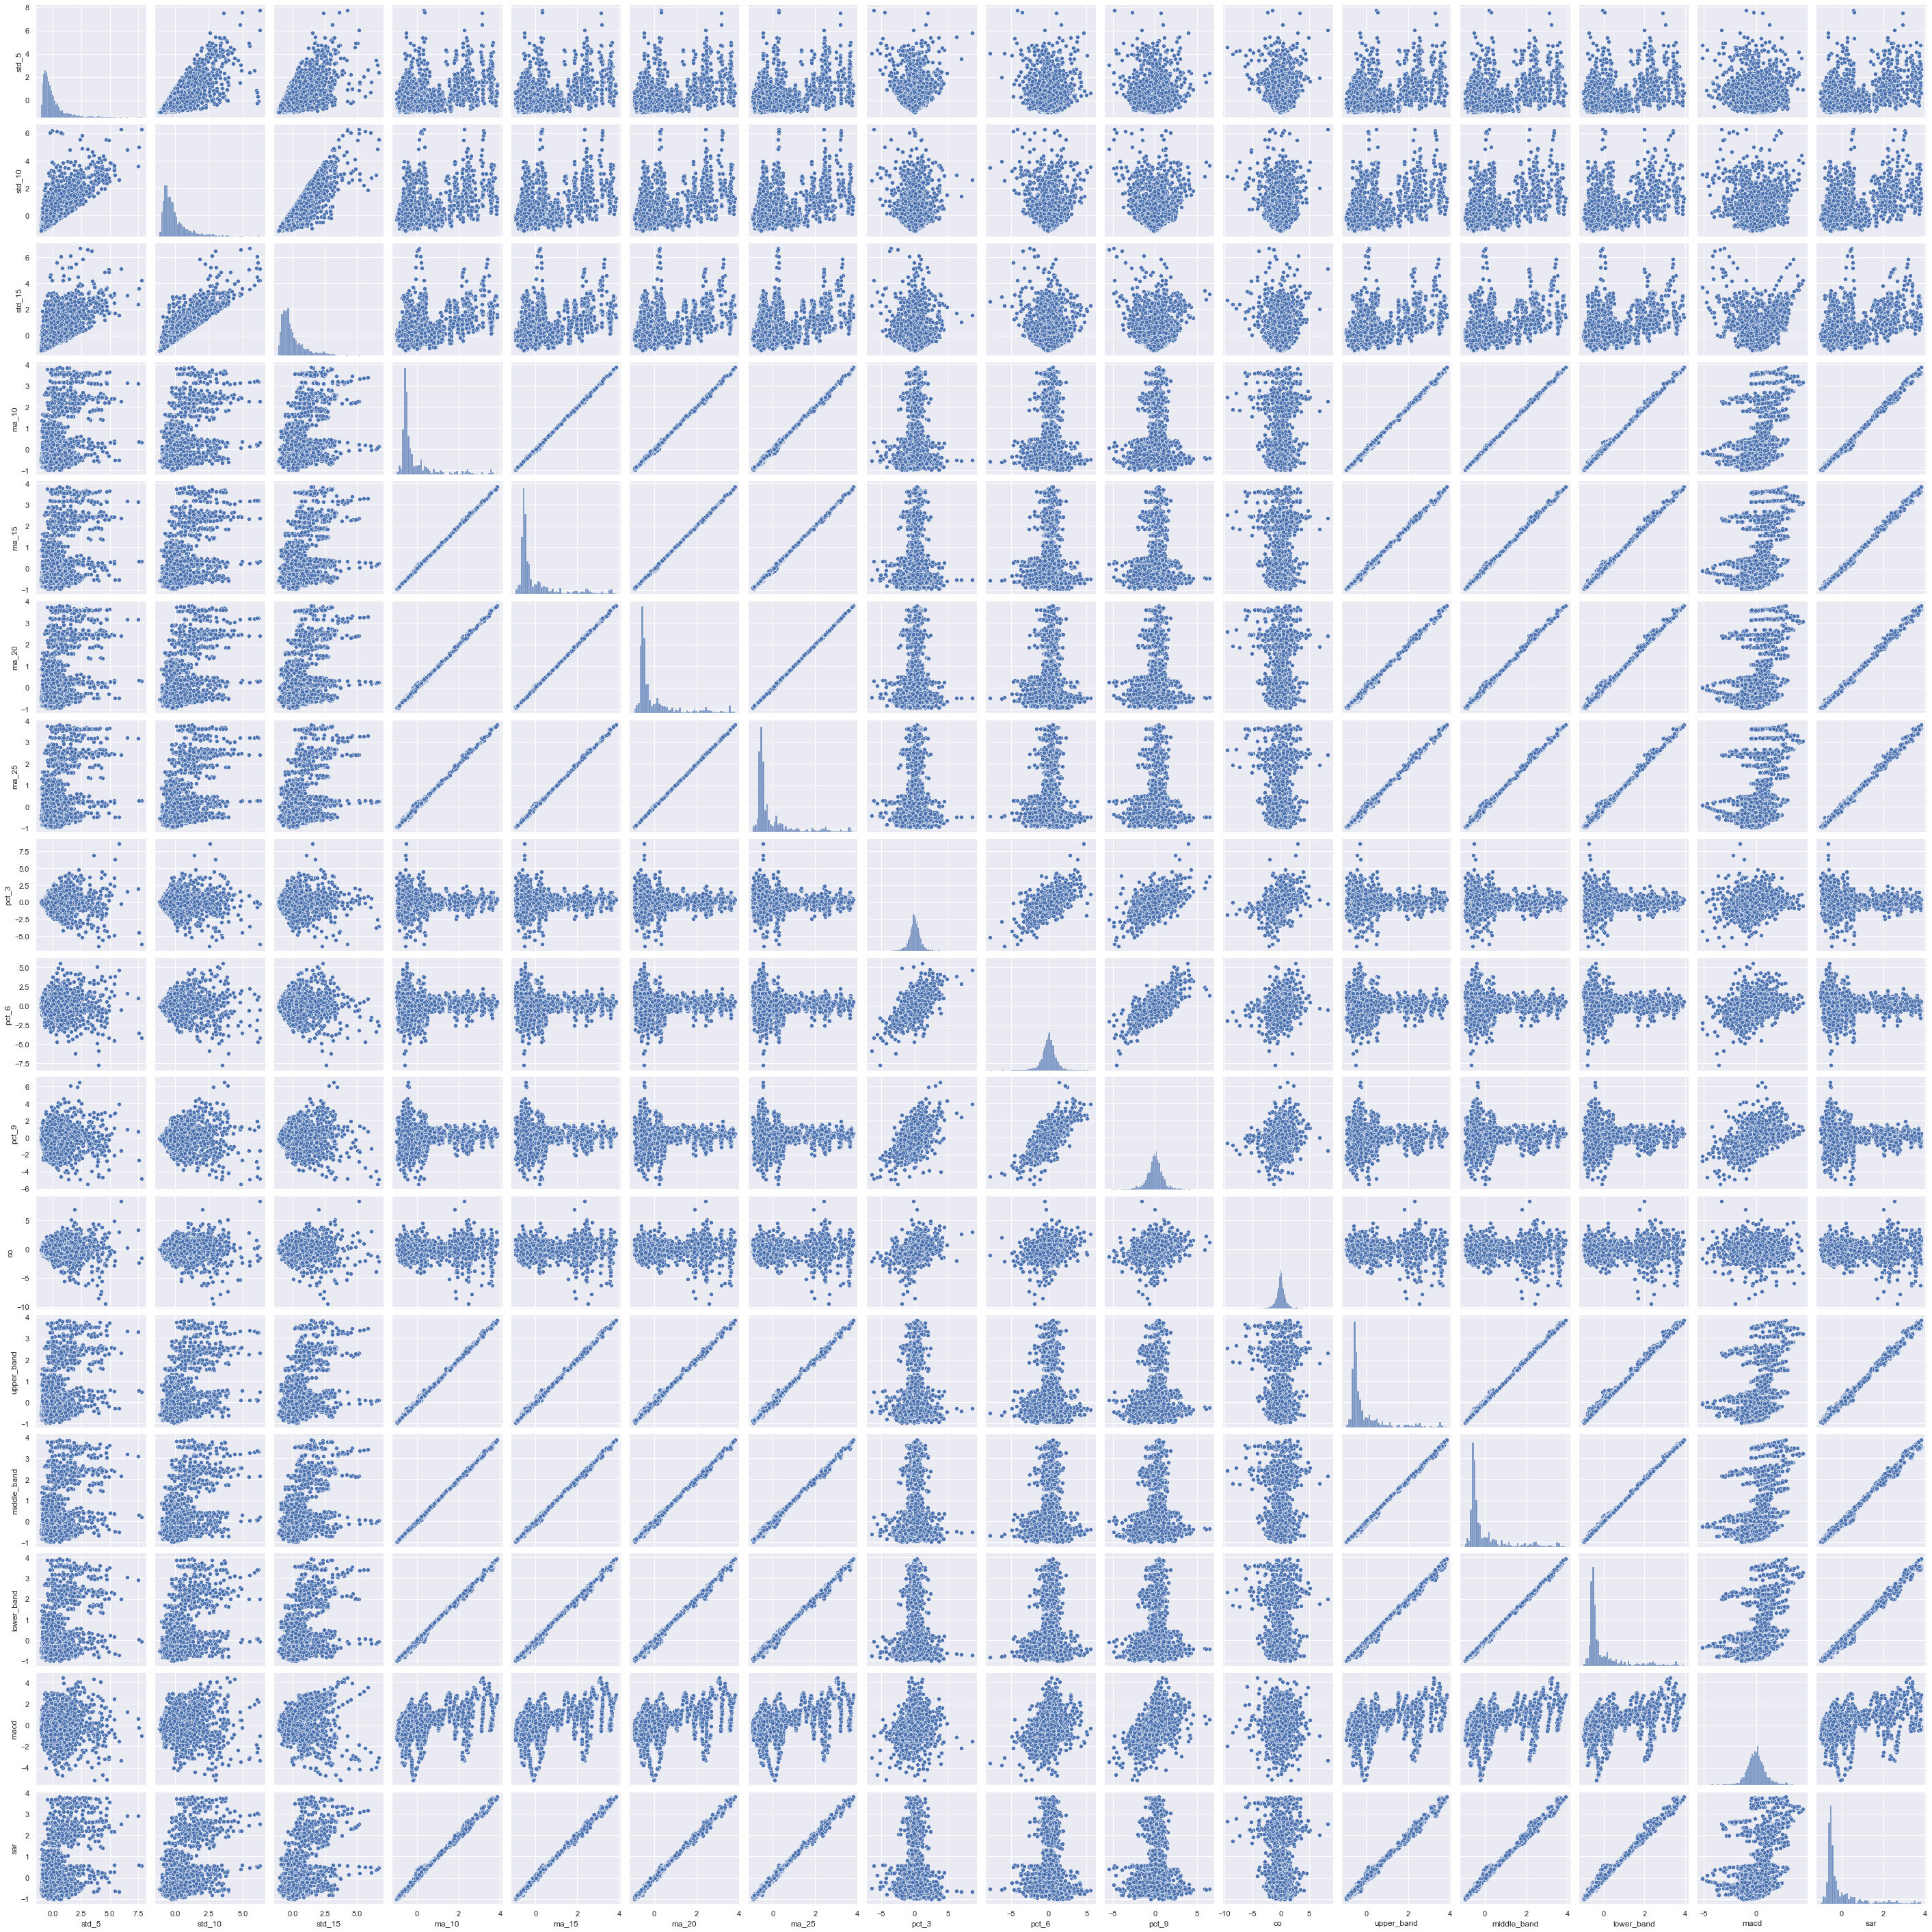

In [18]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
sns.pairplot(X_train_scaled_df[features_list]);

In [19]:
X_train_scaled_df.describe().round(2).T

count  mean  std   min   25%   50%   75%   max
std_5        3973.0   0.0  1.0 -1.02 -0.62 -0.30  0.23  7.75
std_10       3973.0  -0.0  1.0 -1.14 -0.65 -0.31  0.28  6.29
std_15       3973.0   0.0  1.0 -1.14 -0.65 -0.33  0.30  6.66
ma_10        3973.0   0.0  1.0 -0.96 -0.56 -0.45  0.13  3.86
ma_15        3973.0   0.0  1.0 -0.95 -0.56 -0.44  0.14  3.85
ma_20        3973.0  -0.0  1.0 -0.94 -0.56 -0.44  0.14  3.80
ma_25        3973.0  -0.0  1.0 -0.93 -0.56 -0.44  0.15  3.80
pct_3        3973.0  -0.0  1.0 -6.46 -0.46  0.01  0.49  8.61
pct_6        3973.0  -0.0  1.0 -7.76 -0.50  0.02  0.52  5.56
pct_9        3973.0  -0.0  1.0 -5.49 -0.48  0.03  0.53  6.48
co           3973.0  -0.0  1.0 -9.41 -0.37 -0.00  0.43  8.37
upper_band   3973.0  -0.0  1.0 -0.96 -0.57 -0.45  0.14  3.85
middle_band  3973.0  -0.0  1.0 -0.97 -0.56 -0.45  0.13  3.90
lower_band   3973.0  -0.0  1.0 -1.00 -0.56 -0.44  0.12  3.94
macd         3973.0  -0.0  1.0 -5.15 -0.52 -0.01  0.50  4.43
sar          3973.0  -0.0  1.0 -1.00 -0.56 -0.44  0.13  3.80

In [20]:
from sklearn.neural_network import MLPClassifier

In [21]:
# Define model
model = MLPClassifier(hidden_layer_sizes=(5), verbose=True, random_state=10)

# Train model
model.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.75687873
Iteration 2, loss = 0.73029523
Iteration 3, loss = 0.71637723
Iteration 4, loss = 0.70852432
Iteration 5, loss = 0.70422875
Iteration 6, loss = 0.70129704
Iteration 7, loss = 0.69943904
Iteration 8, loss = 0.69818639
Iteration 9, loss = 0.69706672
Iteration 10, loss = 0.69629113
Iteration 11, loss = 0.69559825
Iteration 12, loss = 0.69487878
Iteration 13, loss = 0.69433126
Iteration 14, loss = 0.69390596
Iteration 15, loss = 0.69343715
Iteration 16, loss = 0.69311716
Iteration 17, loss = 0.69298244
Iteration 18, loss = 0.69256876
Iteration 19, loss = 0.69238643
Iteration 20, loss = 0.69201430
Iteration 21, loss = 0.69182242
Iteration 22, loss = 0.69172064
Iteration 23, loss = 0.69140601
Iteration 24, loss = 0.69129160
Iteration 25, loss = 0.69104604
Iteration 26, loss = 0.69094607
Iteration 27, loss = 0.69080101
Iteration 28, loss = 0.69053518
Iteration 29, loss = 0.69044067
Iteration 30, loss = 0.69037007
Iteration 31, loss = 0.69021169
Iteration 32, los

MLPClassifier(hidden_layer_sizes=5, random_state=10, verbose=True)

In [22]:
# Check number of layers in the model
model.n_layers_

3

In [23]:
# Check weights
print('Weights between input layer and the hidden layer:')
print(model.coefs_[0])

Weights between input layer and the hidden layer:
[[ 0.2578114  -0.45299356  0.15777176  0.03986497  0.09426396]
 [-0.38227644 -0.23957702  0.35279042 -0.42651812 -0.53567985]
 [ 0.02568734  0.49269185 -0.4312236   0.07416695  0.31813729]
 [ 0.06561056  0.17707615 -0.231731    0.47020039  0.13345693]
 [-0.00816077 -0.44245562 -0.14688067  0.21112717 -0.16670313]
 [-0.12690496  0.06351271  0.00139447  0.18816748  0.0028573 ]
 [ 0.26715379 -0.04390364  0.41944773 -0.16090385 -0.54119016]
 [-0.1850066  -0.18201871  0.16624541 -0.82482599 -0.10006759]
 [-0.03351513  0.26821171 -0.37060606  0.23677602  0.03675402]
 [ 0.07712925 -0.12323138  0.30010435 -0.34763412 -0.08462858]
 [ 0.03379877 -0.31245283  0.17300958 -0.42984589 -0.35485851]
 [ 0.41668487  0.46442402 -0.05196534  0.3633129  -0.34276715]
 [ 0.04496571  0.37118787  0.03097819  0.11932692 -0.57416983]
 [-0.21269865 -0.51147934 -0.21465873 -0.14951047  0.20614536]
 [-0.22045697  0.16152706  0.10421368 -0.11105328 -0.29157596]
 [-0.

In [24]:
print('Weights between hidden layer and the output layer:')
print(model.coefs_[1])

Weights between hidden layer and the output layer:
[[-0.74592054]
 [-0.18862444]
 [-0.33613982]
 [ 0.20896353]
 [ 0.19777139]]


In [25]:
# Check model accuracy on training data
print('Model accuracy on training data:', model.score(X_train_scaled, y_train))

Model accuracy on training data: 0.5376289957211176


In [26]:
# Check model accuracy on testing data
print('Model accuracy on testing data:', model.score(X_test_scaled, y_test))

Model accuracy on testing data: 0.5160965794768612


In [27]:
y_pred = model.predict(X_test_scaled)


In [28]:
X_train_scaled

array([[-0.30133011, -0.09504985, -0.20701987, ...,  0.53078245,
         1.15405715,  0.48261149],
       [-0.60717845, -0.22673582, -0.19243709, ...,  0.06961024,
         0.19014398,  0.13082296],
       [-0.24338607, -0.22817317, -0.47987332, ..., -0.30976032,
        -0.13426392, -0.28052706],
       ...,
       [-0.45404512, -0.77978831, -0.95104388, ..., -0.40247557,
         0.35984787, -0.39229749],
       [-0.18982731, -0.36688233, -0.39596953, ..., -0.58871336,
        -0.9026009 , -0.55244994],
       [ 1.2842743 ,  1.41277441,  1.42108892, ...,  1.81582265,
        -0.86369001,  1.98688556]])

In [29]:
model.predict_proba(X_test_scaled)

array([[0.46539673, 0.53460327],
       [0.50800861, 0.49199139],
       [0.48502654, 0.51497346],
       ...,
       [0.52455916, 0.47544084],
       [0.49945719, 0.50054281],
       [0.45964184, 0.54035816]])

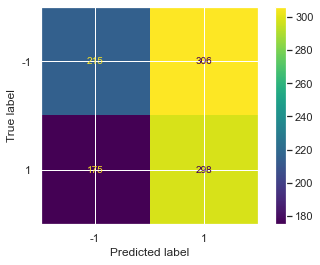

In [30]:
fig = plot_confusion_matrix(model, X_test_scaled, y_test, display_labels = model.classes_)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.55      0.41      0.47       521
           1       0.49      0.63      0.55       473

    accuracy                           0.52       994
   macro avg       0.52      0.52      0.51       994
weighted avg       0.52      0.52      0.51       994



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


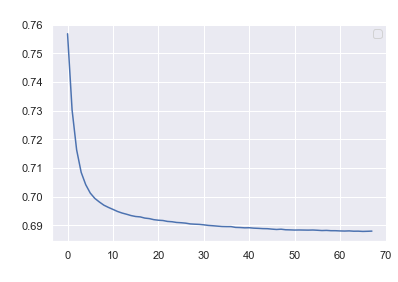

In [32]:
plt.plot(model.loss_curve_)
plt.title("Loss Curve", fontsize = 14, color='white')
plt.xlabel('Iterations', color='white')
plt.ylabel('Cost', color='white')
plt.legend(loc='best',labelcolor='white')
plt.savefig('loss_curve',dpi=300)

plt.show()

As training and testing accuracy are very similar, we can consider that model might not have overfitted, and it can generalize well. However, it is difficult to claim until we are test it on validation set/s.

Also, the model that we have created is a very simple one; we have used most of the default parameters for building the model. And they might not be the best one. 

## Part 2 - Backtesting our predictions


In [33]:
def backtest(df, model):
    # Copy data
    data = df.copy()
    
    # Create returns
    data['returns'] = np.log(data['Close'] / data['Close'].shift(1))
    # Creating features
    features_list = []

    # SD based features
    for i in range(5, 20, 5):
        col_name = 'std_' + str(i)
        data[col_name] = data['Close'].rolling(window=i).std()
        features_list.append(col_name)

    # MA based features
    for i in range(10, 30, 5):
        col_name = 'ma_' + str(i)
        data[col_name] = data['Close'].rolling(window=i).mean()
        features_list.append(col_name)

    # Daily pct change based features
    for i in range(3, 12, 3):
        col_name = 'pct_' + str(i)
        data[col_name] = data['Close'].pct_change().rolling(i).sum()
        features_list.append(col_name)

    # Intraday movement
    col_name = 'co'
    data[col_name] = data['Close'] - data['Open']
    features_list.append(col_name)
    # Create features
    data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(data['Close'].values)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['Close'].values)
    data['sar'] = ta.SAR(data['High'].values, data['Low'].values)
    features_list +=['upper_band','middle_band','lower_band','macd','sar']
    # Create target
    data['target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
    
    # Drop null values
    data.dropna(inplace=True)
    
    # Create feature matrix and target vector
    X = data[features_list]
    y = data['target']
    
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Predict
    y_pred = model.predict(X_scaled)
    
    data['predicted'] = y_pred
    
    # Create strategy returns
    data['strategy_returns'] = data['returns'].shift(-1) * data['predicted']
    
    # Return the last cumulative return
    bnh_returns = data['returns'].cumsum()[-1]
    
    # Return the last cumulative strategy return
    # we need to drop the last nan value
    data.dropna(inplace=True)
    strategy_returns = data['strategy_returns'].cumsum()[-1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(data['returns'].cumsum())
    plt.plot(data['strategy_returns'].cumsum())
    plt.xlabel('Time', color='white')
    plt.ylabel('Cumulative Returns', color='white')
    plt.title('Returns Comparison', color='white')
    plt.legend(loc='best',labelcolor='white')
    plt.savefig('Returns',dpi=300)
    plt.show()

    
    return bnh_returns, strategy_returns

[*********************100%***********************]  1 of 1 completed

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


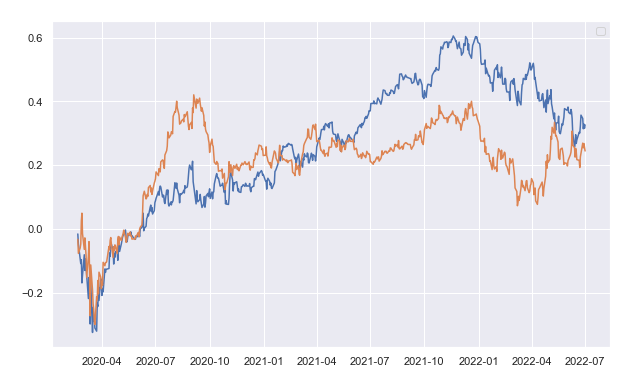

Strategy Returns: 0.33897873382139104
Buy and Hold Returns: 0.2448532962725234


In [34]:
# Read backtest data
start1=datetime.date(2020,1,2)
end1=datetime.date(2022,7,6)
backtest_data = yf.download('MSFT',start=start1,end=end1)
# Backtest_data = pd.read_csv('EURUSD_backtest.csv', index_col=0, parse_dates=True)
# Backtest the strategy
bnh_returns, s_returns = backtest(backtest_data, model)

print('Strategy Returns:', bnh_returns);
print('Buy and Hold Returns:', s_returns);